In [ ]:
'''
File 7 of 8 of kdd pipeline

Key features: investigating features and building a model for: energy_above_hull
'''

In [147]:
import pandas as pd

numerical_df = pd.read_csv("../dataset/cleaned_numerical_data.csv")
numerical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155361 entries, 0 to 155360
Data columns (total 45 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   nsites                                        155361 non-null  int64  
 1   nelements                                     155361 non-null  int64  
 2   volume                                        155361 non-null  float64
 3   density                                       155361 non-null  float64
 4   density_atomic                                155361 non-null  float64
 5   deprecated                                    155361 non-null  int64  
 6   energy_per_atom                               152149 non-null  float64
 7   formation_energy_per_atom                     152149 non-null  float64
 8   energy_above_hull                             152149 non-null  float64
 9   is_stable                                     15

In [148]:
#split data into real and theoretical subsets model on real values first

numerical_df.drop(['deprecated'], axis=1, inplace=True)

real_df = numerical_df[numerical_df['theoretical'] == 0].copy()
theoretical_df = numerical_df[numerical_df['theoretical'] == 1].copy()

real_df.drop(['theoretical'], axis=1, inplace=True)
theoretical_df.drop(['theoretical'], axis=1, inplace=True)

print("Real df shape:", real_df.shape)
print("Theoretical df shape:", theoretical_df.shape)

Real df shape: (49772, 43)
Theoretical df shape: (105589, 43)


In [149]:
real_df['energy_above_hull'].describe()
#data is skewed right

count    48674.000000
mean         0.078645
std          0.234367
min          0.000000
25%          0.000000
50%          0.001233
75%          0.042973
max          5.146383
Name: energy_above_hull, dtype: float64

In [150]:
'''
Option for dealing with null values for target value
'''
print(real_df['energy_above_hull'].isna().sum())
print(theoretical_df['energy_above_hull'].isna().sum())

real_df['energy_above_hull'] = real_df['energy_above_hull'].fillna(real_df['energy_above_hull'].median())
theoretical_df['energy_above_hull'] = theoretical_df['energy_above_hull'].fillna(real_df['energy_above_hull'].median())

print(real_df['energy_above_hull'].isna().sum())
print(theoretical_df['energy_above_hull'].isna().sum())

1098
2114
0
0


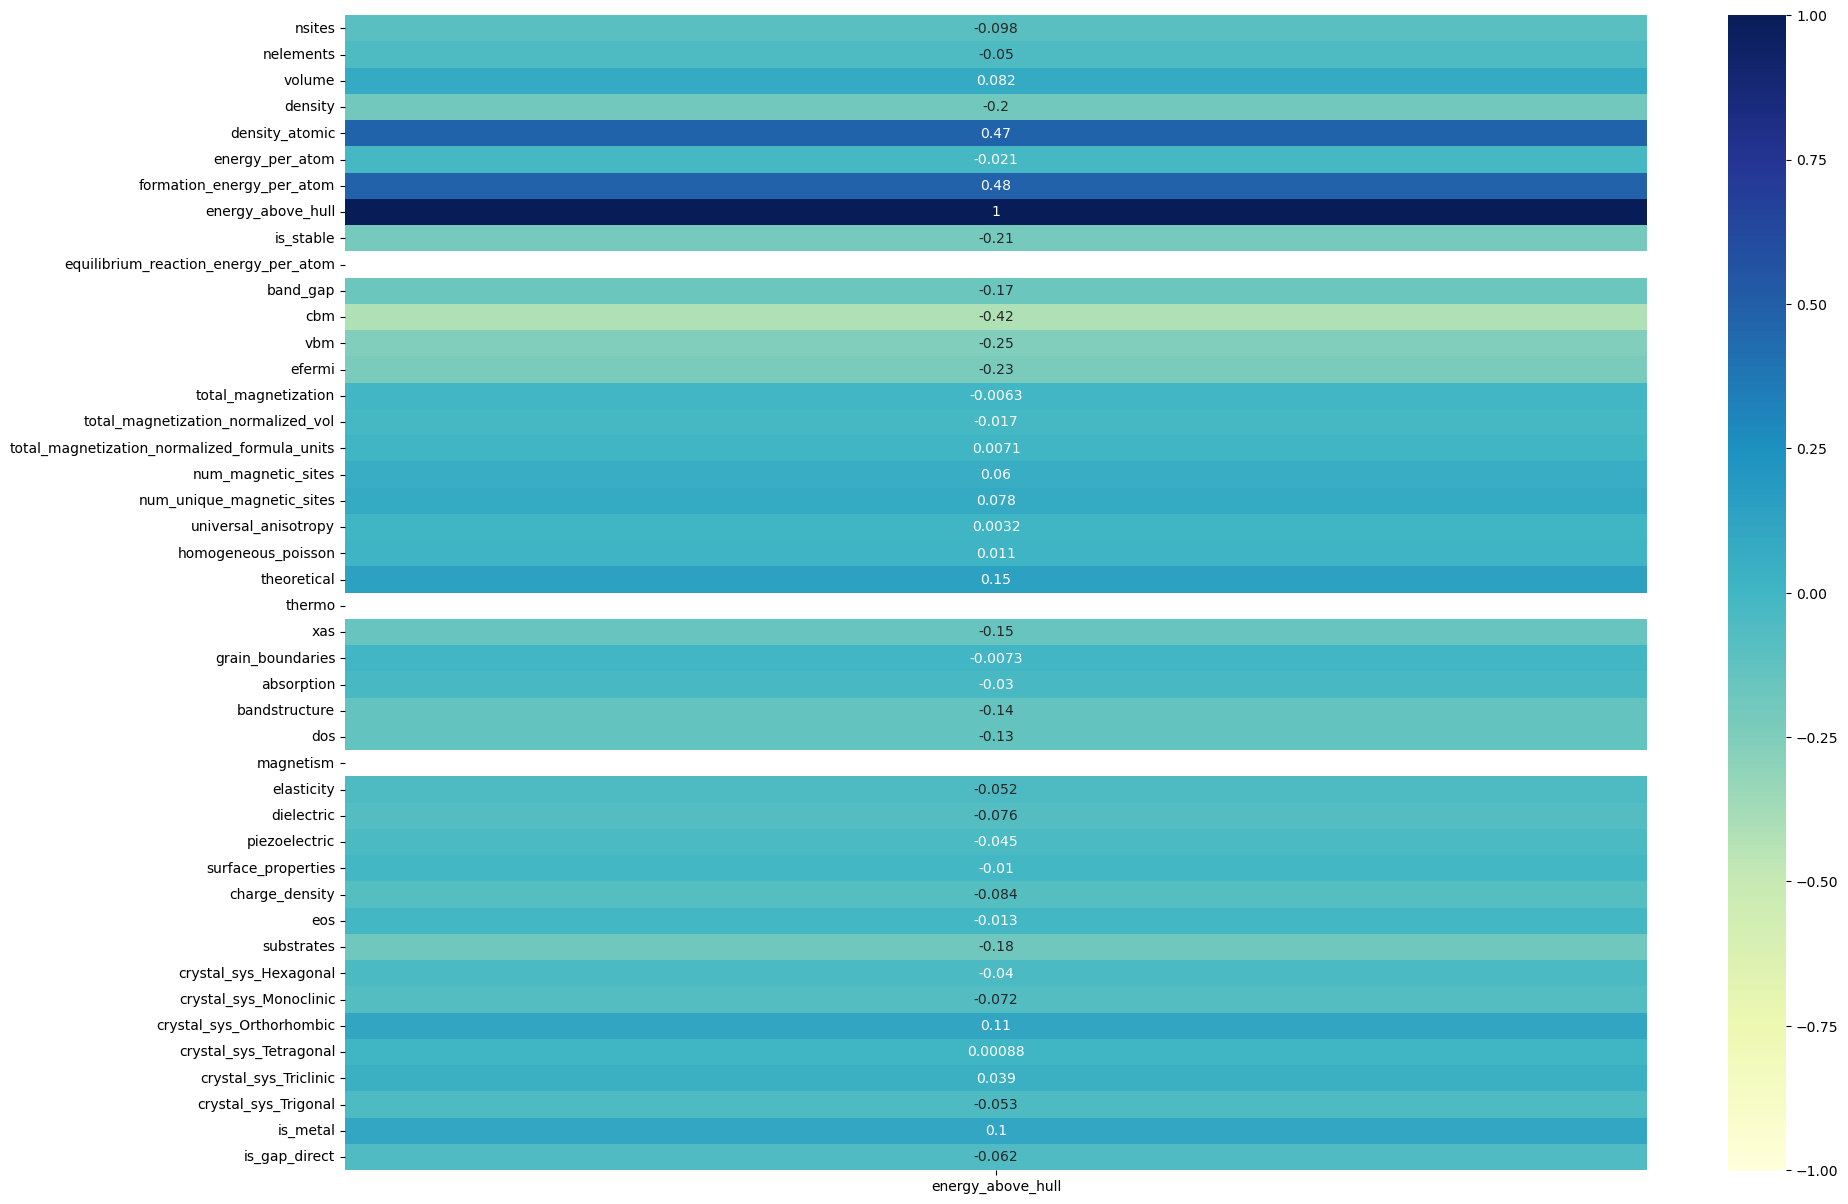

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(21, 15))
corr_matrix = numerical_df.corr()

corr_band_gap = corr_matrix[['energy_above_hull']]
sns.heatmap(corr_band_gap, annot=True, cmap="YlGnBu", vmin=-1, vmax=1)

plt.show()

In [152]:
#Train a model for band_gap on real molecules

from sklearn.model_selection import train_test_split

#features to train with below --- these have been selected through training the and testing the model rigorously 
feature_names = ["density_atomic", "is_stable", "crystal_sys_Orthorhombic","bandstructure", "dos",
                 "energy_per_atom", "is_metal", "efermi" ,"formation_energy_per_atom","density"]

X = real_df[feature_names]
X = X.fillna(X.median(numeric_only=True)) #fill for knn model

y = real_df["energy_above_hull"]
train_X, test_x, train_y, test_y = train_test_split(X, y, train_size = 0.2, random_state=1)

#Get train, test and theoretical sets:
theoretical_df = theoretical_df.dropna(subset=['energy_above_hull'])

theoretical_x = theoretical_df[feature_names]
theoretical_x = theoretical_x.fillna(theoretical_x.median(numeric_only=True)) #fill for knn model

theoretical_y = theoretical_df['energy_above_hull']

In [153]:
from sklearn.tree import DecisionTreeRegressor

dtr_model = DecisionTreeRegressor(    
    max_depth=30,#Best performance on theoretical set with 15
    min_samples_split=20, #Best performance on theoretical set with 50
    min_samples_leaf=10,#Best performance on theoretical set with 10
    max_features='sqrt',
    criterion='squared_error',
)
dtr_model.fit(train_X, train_y)

DecisionTreeRegressor(max_depth=30, max_features='sqrt', min_samples_leaf=10,
                      min_samples_split=20)

In [154]:
#Tree Model on Train, Test and Theoretical Sets

from sklearn.metrics import r2_score, root_mean_squared_error

# Predict on Train Set
train_predictions = dtr_model.predict(train_X)
train_r2 = r2_score(train_y, train_predictions)
train_rmse = root_mean_squared_error(train_y, train_predictions)
train_relative_rmse = train_rmse / train_y.mean()

# Predict on Test Set
test_predictions = dtr_model.predict(test_x)
test_r2 = r2_score(test_y, test_predictions)
test_rmse = root_mean_squared_error(test_y, test_predictions)
test_relative_rmse = test_rmse / test_y.mean()

#predict on theoretical data
theoretical_predictions = dtr_model.predict(theoretical_x)
theoretical_r2 = r2_score(theoretical_y, theoretical_predictions)
theoretical_rmse = root_mean_squared_error(theoretical_y, theoretical_predictions)
theoretical_relative_rmse = theoretical_rmse / theoretical_y.mean()

# Create a DataFrame for the tree metrics
tree_metrics = {
    'Dataset': ['Train Set', 'Test Set', 'Theoretical Set'],
    'R-squared': [f"{train_r2:.3f}", f"{test_r2:.3f}", f"{theoretical_r2:.3f}"],
    'Root Mean Squared Error': [f"{train_rmse:.3f}", f"{test_rmse:.3f}", f"{theoretical_rmse:.3f}"],
    'Relative RMSE': [f"{train_relative_rmse:.3f}", f"{test_relative_rmse:.3f}", f"{theoretical_relative_rmse:.3f}"]
}
df_tree_metrics = pd.DataFrame(tree_metrics)
print(df_tree_metrics)
df_tree_metrics.to_csv('../performance_metrics/energy_above_hull_tree.csv', index=False)


           Dataset R-squared Root Mean Squared Error Relative RMSE
0        Train Set     0.725                   0.123         1.570
1         Test Set     0.550                   0.155         2.028
2  Theoretical Set     0.440                   0.388         1.770


In [155]:
from sklearn.ensemble import RandomForestRegressor

# Fitting Random Forest Regression to the dataset
rfr = RandomForestRegressor(
    oob_score=True,
    max_depth=15,#Best performance on theoretical set with 15
    min_samples_split=20, #Best performance on theoretical set with 50
    min_samples_leaf=10,#Best performance on theoretical set with 10
    max_features='sqrt',
    criterion='squared_error',
    n_estimators=20 #best performed with 20
)

rfr.fit(train_X, train_y)
# Fit the regressor with x and y data

RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_leaf=10,
                      min_samples_split=20, n_estimators=20, oob_score=True)

In [156]:
#Forest Model on Train, Test and Theoretical Sets

from sklearn.metrics import r2_score, root_mean_squared_error

# Predict on Train Set
train_predictions = rfr.predict(train_X)
train_r2 = r2_score(train_y, train_predictions)
train_rmse = root_mean_squared_error(train_y, train_predictions)
train_relative_rmse = train_rmse / train_y.mean()

# Predict on Test Set
test_predictions = rfr.predict(test_x)
test_r2 = r2_score(test_y, test_predictions)
test_rmse = root_mean_squared_error(test_y, test_predictions)
test_relative_rmse = test_rmse / test_y.mean()

#predict on theoretical data
theoretical_predictions = rfr.predict(theoretical_x)
theoretical_r2 = r2_score(theoretical_y, theoretical_predictions)
theoretical_rmse = root_mean_squared_error(theoretical_y, theoretical_predictions)
theoretical_relative_rmse = theoretical_rmse / theoretical_y.mean()

# Create a DataFrame for the metrics
forest_metrics = {
    'Dataset': ['Train Set', 'Test Set', 'Theoretical Set'],
    'R-squared': [f"{train_r2:.3f}", f"{test_r2:.3f}", f"{theoretical_r2:.3f}"],
    'Root Mean Squared Error': [f"{train_rmse:.3f}", f"{test_rmse:.3f}", f"{theoretical_rmse:.3f}"],
    'Relative RMSE': [f"{train_relative_rmse:.3f}", f"{test_relative_rmse:.3f}", f"{theoretical_relative_rmse:.3f}"]
}

df_forest_metrics = pd.DataFrame(forest_metrics)
print(df_forest_metrics)
df_forest_metrics.to_csv('../performance_metrics/energy_above_hull_forest.csv', index=False)

           Dataset R-squared Root Mean Squared Error Relative RMSE
0        Train Set     0.746                   0.118         1.507
1         Test Set     0.680                   0.131         1.711
2  Theoretical Set     0.595                   0.330         1.506


In [157]:
#Forest Model on Train, Test and Theoretical Sets

from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(
                        n_neighbors=3, #Best performing neighbors
                        p=2, #best performing penalty - L2 Euclidean
                        algorithm='auto', #best performing alg
                        weights='distance', #best performing distance - highly overfits mode though
                        
                        )
knn.fit(train_X, train_y)

KNeighborsRegressor(n_neighbors=3, weights='distance')

In [158]:
#KNN regressor model 

# Predict on Train Set
train_predictions = knn.predict(train_X)
train_r2 = r2_score(train_y, train_predictions)
train_rmse = root_mean_squared_error(train_y, train_predictions)
train_relative_rmse = train_rmse / train_y.mean()

# Predict on Test Set
test_predictions = knn.predict(test_x)
test_r2 = r2_score(test_y, test_predictions)
test_rmse = root_mean_squared_error(test_y, test_predictions)
test_relative_rmse = test_rmse / test_y.mean()

#predict on theoretical data
theoretical_predictions = knn.predict(theoretical_x)
theoretical_r2 = r2_score(theoretical_y, theoretical_predictions)
theoretical_rmse = root_mean_squared_error(theoretical_y, theoretical_predictions)
theoretical_relative_rmse = theoretical_rmse / theoretical_y.mean()

# Create a DataFrame for the metrics
forest_metrics = {
    'Dataset': ['Train Set', 'Test Set', 'Theoretical Set'],
    'R-squared': [f"{train_r2:.4f}", f"{test_r2:.3f}", f"{theoretical_r2:.3f}"],
    'Root Mean Squared Error': [f"{train_rmse:.3f}", f"{test_rmse:.3f}", f"{theoretical_rmse:.3f}"],
    'Relative RMSE': [f"{train_relative_rmse:.3f}", f"{test_relative_rmse:.3f}", f"{theoretical_relative_rmse:.3f}"]
}

df_forest_metrics = pd.DataFrame(forest_metrics)
print(df_forest_metrics)
df_forest_metrics.to_csv('../performance_metrics/energy_above_hull_knn.csv', index=False)

           Dataset R-squared Root Mean Squared Error Relative RMSE
0        Train Set    1.0000                   0.000         0.000
1         Test Set     0.390                   0.181         2.360
2  Theoretical Set     0.112                   0.489         2.230
